In [100]:
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from scipy import optimize
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

### From James's Original Code, Loads and Preprocess Signal Data From File

In [101]:
with open("2022-11-05_23-29-51__2022-11-06_11-20-39.txt","r") as eventfile:
    df = pd.read_json(eventfile, lines=True)
df['stop_time'] = pd.to_datetime(df['stop_time'])
df.set_index('stop_time', inplace=True)

### Create All Empty Lists

In [102]:
# Store fit results
fit_results = []

# Make Time_steps list
time = df['pol'].index

# Extract time portion (hh:mm:ss) as string 
time_held = pd.Series(time).dt.time.astype(str).tolist()

# Create lists for Gaussian Variables
amp1_list, amp2_list, amp3_list = [], [], []
cen1_list, cen2_list, cen3_list = [], [], []
wid1_list, wid2_list, wid3_list = [], [], []

amp1_error, amp2_error, amp3_error = [], [], []
cen1_error, cen2_error, cen3_error = [], [], []
wid1_error, wid2_error, wid3_error = [], [], []

# Set the fixed values for the centers and widths
cen1 = np.mean(cen1_list[21:])
wid1 = np.mean(wid1_list[21:])
cen2 = np.mean(cen2_list[21:])
wid2 = np.mean(wid2_list[21:])
cen3 = np.mean(cen3_list[21:])
wid3 = np.mean(wid3_list[21:])

C:\Users\Direc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Direc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Define Gaussian(s)

In [103]:
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

def three_gaussians(x, *params):
    return sum(gaussian(x, *params[i:i+3]) for i in range(0, 9, 3))

def held_gaussians(x, amp1, amp2, amp3):
    return (gaussian(x, amp1, cen1, wid1) + gaussian(x, amp2, cen2, wid2) + gaussian(x, amp3, cen3, wid3))

In [104]:
# Fit and plot individual curve
def plot_pol_array_with_fit(index):
    plt.figure(figsize=(10, 6))
    signal_array = df.iloc[index]['rescurve']
    x_data = np.arange(len(signal_array))

    mean_val = np.mean(signal_array)
    initial_guess = [
        mean_val / 3, len(signal_array) / 4, 100,
        mean_val / 3, len(signal_array) / 2, 100,
        mean_val / 3, 3 * len(signal_array) / 4, 100
    ]

    try:
        # Fit and get covariance matrix
        popt, pcov = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess, maxfev = 10000)
        perr = np.sqrt(np.diag(pcov))  # <-- Extract uncertainties

        # Print parameters and uncertainties
        for i in range(3):
            amp, cen, wid = popt[i*3:i*3+3]
            amp_err, cen_err, wid_err = perr[i*3:i*3+3]
            print(f"Gaussian {i+1}:")
            print(f"Amplitude = {amp:.4f} ± {amp_err:.4f}")
            print(f"Center    = {cen:.2f} ± {cen_err:.2f}")
            print(f"Width     = {wid:.2f} ± {wid_err:.2f}")

        # Append results
        fit_results.append({
            'index': index,
            'time': df.index[index],
            'pol': df.iloc[index]['pol'],
            'params': popt
        })

        # Plot original and fit
        plt.plot(x_data, signal_array, label='Original Signal', linewidth=2)
        plt.plot(x_data, three_gaussians(x_data, *popt), '--', color='red', label='Total Fit')

        # Plot individual Gaussians
        colors = ['blue', 'green', 'purple']
        for i in range(3):
            amp, cen, wid = popt[i*3:i*3+3]
            g = gaussian(x_data, amp, cen, wid)
            label = f'Gaussian{i+1}'
            plt.plot(x_data, g, linestyle=':', color=colors[i], label=label)

        plt.title(f"Signal {index} | Polarization: {df.iloc[index]['pol']:.2f}")
        plt.xlabel("Index")
        plt.ylabel("Signal")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    except RuntimeError:
        print(f"Fit failed for row {index}")

# Create slider
interact(plot_pol_array_with_fit,
         index=IntSlider(min=0, max=len(df)-1, step=1, value=9, description='Row Index:'))

interactive(children=(IntSlider(value=9, description='Row Index:', max=131), Output()), _dom_classes=('widget-…

<function __main__.plot_pol_array_with_fit(index)>

In [105]:
def plot_pol_array_with_fit(index):
    plt.figure(figsize=(10,6))
    signal_array = df.iloc[index]['rescurve']
    x_data = np.arange(len(signal_array))

    # Initial guess for parameters of each gaussian
    mean_val = np.mean(signal_array)

    initial_guess = [3*mean_val / 6,
                     2*mean_val / 6,
                     mean_val / 6]

    try:
        # Perform curve fitting
        popt, pcov = curve_fit(held_gaussians, x_data, signal_array, p0=initial_guess, maxfev = 10000)
        perr = np.sqrt(np.diag(pcov))

        amp1_list.append(popt[0])
        amp2_list.append(popt[1])
        amp3_list.append(popt[2])
        amp1_error.append(perr[0])
        amp2_error.append(perr[1])
        amp3_error.append(perr[2])  
              

        return amp1_list, amp2_list, amp3_list, amp1_error, amp2_error, amp3_error
    
    except RuntimeError:
        amp1_list.append(np.nan)
        amp2_list.append(np.nan)
        amp3_list.append(np.nan)
        amp1_error.append(np.nan)
        amp2_error.append(np.nan)
        amp3_error.append(np.nan)
        print(f"Fit failed for row {index}")

# ...
for i in range(len(df)):
    plot_pol_array_with_fit(i)

C:\Users\Direc\AppData\Local\Temp\ipykernel_9396\2920620034.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(held_gaussians, x_data, signal_array, p0=initial_guess, maxfev = 10000)
C:\Users\Direc\AppData\Local\Temp\ipykernel_9396\2920620034.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,6))


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<function matplotlib.pyplot.show(close=None, block=None)>

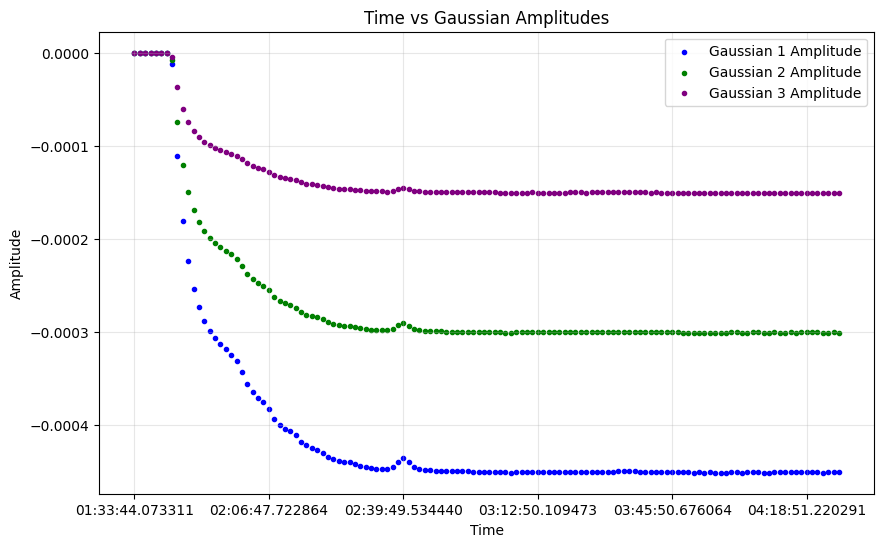

In [107]:
plt.figure(figsize=(10, 6))

plt.scatter(time_held, amp1_list, label='Gaussian 1 Amplitude', color='blue', marker='.')
plt.errorbar(time_held, amp1_list, yerr=amp1_error, color='blue', ls=f' ')

plt.scatter(time_held, amp2_list, label='Gaussian 2 Amplitude', color='green', marker='.')
plt.scatter(time_held, amp3_list, label='Gaussian 3 Amplitude', color='purple', marker='.')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title("Time vs Gaussian Amplitudes")
plt.grid(True, alpha=0.3)
ax = plt.gca() # Get current axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
plt.legend()
plt.show